In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ouassimanischihati","key":"f10109902d83dcb46ec83f537ed2f7ed"}'}

importing the DATASET from kaggle.com

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 321M/325M [00:03<00:00, 92.8MB/s]
100% 325M/325M [00:04<00:00, 84.5MB/s]


unzip the FILE.ZIP

In [6]:
from zipfile import ZipFile

file_name="skin-cancer-malignant-vs-benign.zip"
with ZipFile(file_name, 'r') as zip :

     zip.extractall()
     print("done")

done


DEFINE THE CALLBACK

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

class MyCallback(keras.callbacks.Callback) :
  def on_epoch_end(self, epochs, logs={}):
    if logs.get('acc')>0.80 :
      print('stop training')
      self.stop_training=True

callbacks=MyCallback()

Using TensorFlow backend.


PRECISE THE DIRECTORY For both malignant and benign , we have 2637 training images and 720 validation images.

In [44]:
import os

BASE_DIR='/content/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')

VAL_DIR = os.path.join(BASE_DIR, 'test')

TRAIN_DIR_BENIGN = os.path.join(TRAIN_DIR, 'benign' )

VAL_DIR_BENIGN = os.path.join(VAL_DIR, 'benign' )

TRAIN_DIR_MALIGNANT = os.path.join(TRAIN_DIR, 'malignant' )

VAL_DIR_MALIGNANT = os.path.join(VAL_DIR, 'malignant' )

TRAIN_DIR_BENIGN_LIST=os.listdir(TRAIN_DIR_BENIGN)

TRAIN_DIR_MALIGNANT_LIST=os.listdir(TRAIN_DIR_MALIGNANT)

VAL_DIR_BENIGN_LIST=os.listdir(VAL_DIR_BENIGN)

VAL_DIR_MALIGNANT_LIST=os.listdir(VAL_DIR_BENIGN)

print(os.listdir(TRAIN_DIR_BENIGN))

print(os.listdir(TRAIN_DIR_MALIGNANT))

print(os.listdir(VAL_DIR_BENIGN))

print(os.listdir(VAL_DIR_MALIGNANT))

print(len(TRAIN_DIR_BENIGN_LIST))

print(len(VAL_DIR_BENIGN_LIST))

print(len(TRAIN_DIR_MALIGNANT_LIST))

print(len(VAL_DIR_MALIGNANT_LIST))


['1268.jpg', '650.jpg', '1161.jpg', '1224.jpg', '1148.jpg', '1153.jpg', '102.jpg', '1636.jpg', '1000.jpg', '849.jpg', '1501.jpg', '19.jpg', '1692.jpg', '266.jpg', '1493.jpg', '697.jpg', '701.jpg', '1341.jpg', '1285.jpg', '779.jpg', '489.jpg', '463.jpg', '606.jpg', '852.jpg', '1475.jpg', '55.jpg', '555.jpg', '17.jpg', '1016.jpg', '1015.jpg', '1104.jpg', '804.jpg', '1480.jpg', '672.jpg', '162.jpg', '1086.jpg', '1455.jpg', '947.jpg', '1188.jpg', '1613.jpg', '1097.jpg', '357.jpg', '39.jpg', '853.jpg', '839.jpg', '811.jpg', '890.jpg', '1062.jpg', '1666.jpg', '353.jpg', '747.jpg', '750.jpg', '1351.jpg', '1558.jpg', '1245.jpg', '677.jpg', '1182.jpg', '1454.jpg', '1303.jpg', '1615.jpg', '592.jpg', '730.jpg', '506.jpg', '1050.jpg', '582.jpg', '1684.jpg', '1796.jpg', '954.jpg', '1369.jpg', '666.jpg', '4.jpg', '264.jpg', '426.jpg', '837.jpg', '1539.jpg', '254.jpg', '576.jpg', '933.jpg', '738.jpg', '1248.jpg', '424.jpg', '1043.jpg', '600.jpg', '577.jpg', '1172.jpg', '110.jpg', '500.jpg', '1735.jpg

DATA GENERATORS validation and training

In [17]:


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      #shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      #fill_mode='nearest')
)
validation_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=521,
    class_mode='binary'
    
)
validation_generator = validation_datagen.flow_from_directory(    
    VAL_DIR,
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


THE CONVOLUTIONAL LAYERS AND THE MODEL

In [18]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D( 32 , (3,3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    #keras.layers.Conv2D( 32 , (3,3), activation='relu'),
    #keras.layers.MaxPool2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')

])

model.summary() #defining the summary of the model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 600)              

Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the Machine Learning Crash Course.) We will use the rmsprop optimizer with a learning rate of 0.0001. During training, we will want to monitor classification accuracy.
In this case, using the RMSprop optimization algorithm is preferable 

In [0]:
from tensorflow.keras.optimizers import RMSprop
#compilation
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(lr=0.0001, momentum=0.7), #momuntoum and learning rate
              metrics=['accuracy'])

Let's train on all 2637 images available, for 50 epochs, and validate on all 720 test images. (This may take a few minutes to run.)

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The Validation accuracy is the measurement with the data that has not been used in training

In [20]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=50,
      #verbose = 1
      validation_data = validation_generator,
      validation_steps=8
      )

Epoch 1/50
10/10 [==============================] - 78s 8s/step - loss: 0.7052 - accuracy: 0.5321 - val_loss: 0.6985 - val_accuracy: 0.5393
Epoch 2/50
10/10 [==============================] - 71s 7s/step - loss: 0.6566 - accuracy: 0.6241 - val_loss: 0.6248 - val_accuracy: 0.6965
Epoch 3/50
10/10 [==============================] - 69s 7s/step - loss: 0.6094 - accuracy: 0.6680 - val_loss: 0.6061 - val_accuracy: 0.7544
Epoch 4/50
10/10 [==============================] - 77s 8s/step - loss: 0.5654 - accuracy: 0.7140 - val_loss: 0.5199 - val_accuracy: 0.7063
Epoch 5/50
10/10 [==============================] - 72s 7s/step - loss: 0.5351 - accuracy: 0.7405 - val_loss: 0.5084 - val_accuracy: 0.6954
Epoch 6/50
10/10 [==============================] - 69s 7s/step - loss: 0.5023 - accuracy: 0.7377 - val_loss: 0.4695 - val_accuracy: 0.7773
Epoch 7/50
10/10 [==============================] - 77s 8s/step - loss: 0.4867 - accuracy: 0.7573 - val_loss: 0.4667 - val_accuracy: 0.7293
Epoch 8/50
10/10 [==

Visualizing Intermediate Representations

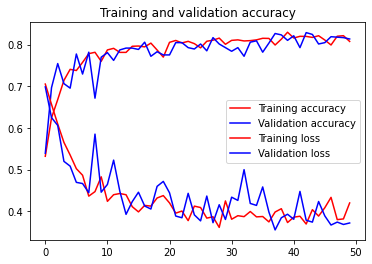

<Figure size 432x288 with 0 Axes>

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
Epochs = range(len(loss))
plt.plot(Epochs, loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

le's give it a try


In [45]:

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(128, 128))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is malignant")
    
  else:
    print(fn + " is benign")

Saving df.PNG to df.PNG
[0.]
df.PNG is benign
